Выполнила: Романенко Александра

## Домашнее задание №1

В этом домашнем задании вы познакомитесь с pytorch сами и сможете попрактиковаться в его применении. 

#### План:

1. Простейшие операции в pytorch
2. Пишем Adam и применяем его к ручной модели
3. Обучаем свою первую нейросеть

In [1]:
import os
import sys
import math
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
device = 'cuda'


### Простейшие операции на pytorch (2 балла)

**Task**: Cоздайте два случайных тензора (двумерных, не квадратных):

In [2]:
x = torch.rand(2, 1)
y = torch.rand(2, 1)

**Task**: Умножьте их друг на друга, результат запишите в третий тензор без использования оператора `=`, для создания третьего тензора предлагается использовать `torch.empty`:

In [3]:
x * y

tensor([[0.2597],
        [0.3967]])

In [4]:
torch.empty(2, 1, out=(x * y))

tensor([[0.2597],
        [0.3967]])

**Task**: Реализуйте ReLU использую только pytorch, примените его к тензору `x` (запрещено использование модулей torch.nn и его подмодулей, а также функции torch.relu)

In [5]:
def relu_forward(x):
    x[x < 0] = 0
    return x

assert torch.all(F.relu(x) == relu_forward(x))

In [6]:
relu_forward(x)

tensor([[0.6743],
        [0.4567]])

**Task**: Сделайте тоже самое c ELU (запрещено использование модулей torch.nn и его подмодулей):

In [7]:
def elu_forward(x):
    x[x < 0] = 1 - torch.exp((x[x < 0]))
    return x

assert torch.allclose(
    F.elu(x),
    elu_forward(x), 
    1e-4
)

**Task**: LeakyReLU (запрещено использование модулей torch.nn и его подмодулей):

In [8]:
def lrelu_forward(x, alpha):
    x[x < 0] = x[x < 0] * alpha
    return x

assert torch.all(F.leaky_relu(x, 0.01) == lrelu_forward(x, 0.01))

**Task**: Теперь перейдем к немного более современным функциям активаций, например Mish, напомним как она выглядит:

$$x * tanh(ln(1+e^x))$$

(запрещено использование модулей torch.nn и его подмодулей)

In [9]:
def mish(x):
    return x * torch.tanh(torch.log(1 + torch.exp(x)))

In [10]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.8651, 0.8651, 0.8651]), 
    atol=1e-4
)

assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64), 
    atol=1e-4
)

**Task**: Теперь реализуем swish, напомним как она выглядит:

$$x * \sigma(x)$$

(запрещено использование модулей torch.nn и его подмодулей)

In [11]:
def swish(x):
    return x * torch.sigmoid(x)

In [12]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.7311, 0.7311, 0.7311]), 
    atol=1e-4
)

assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64), 
    atol=1e-4
)

### Пишем Adam и применяем его к логистической регрессии (4 балла)


В данной секции вам нужно сделать две вещи: 

1. Написать свой собственный оптимизатор подобно тому, который мы писали на семинаре
2. Обучить логистическую регрессию побатчево на картинках из датасета 


#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [13]:
# абстрактный класс, не обращайте внимания
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

**Task**: Напишите свою реализацию Adam:

In [103]:
class Adam(InClassOptimizer):
    def __init__(self, params, lr=0.001, eps=1e-13, beta_1=0.9, beta_2=0.999):
        defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2)
        super().__init__(params, defaults)
        self.m = dict()
        self.v = dict()

    def _group_step(self, group):
        # One group contains information about values passed in init
        # and model parameters to update
        lr = group['lr']
        eps = group['eps']
        beta_1 = group['beta_1']
        beta_2 = group['beta_2']
        for param in filter(lambda x: x.grad is not None, 
                                         group['params']):
          self._init_adam_buffer(param)

          buffer_m, buffer_v = self._get_adagrad_buffer(param)

          d_param = param.grad
          d_norm = d_param ** 2

          m = beta_1 * buffer_m + (1 - beta_1) * d_param
          v = beta_2 * buffer_v + (1 - beta_2) * d_norm
          m_hat = m / (1 - beta_1)
          v_hat = v / (1 - beta_2)
          buffer_m = m_hat
          buffer_v = v_hat


          param.add(lr * buffer_m.grad / torch.sqrt(buffer_v + eps))

    def _get_adam_buffer(self, param):
        """
        Get accumulated gradients for Adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for Adagrad.

        Returns
        -------
        Accumulated Adam gradients for parameter.
        """
        param_state = self.state[param]
        return param_state['adagrad_buffer']

    def _init_adam_buffer(self, param):
        """
        Initialize accumulated gradeints for adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for adam.
        """
        param_state = self.state[param]
        if 'adagrad_buffer' not in param_state:
            param_state['adagrad_buffer'] = torch.zeros_like(param)

**Task**: Создайте параметры для обучения логистической регрессии, сделаем Xavier ициализацию, которая выглядит следующим образом: 

$$w \sim U[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}]$$

где: 

* $n_{in}$ -- размер входа (в нейронах) 
* $n_{out}$ -- размер выхода (в нейронах)

Подумайте над выбором $n_{in}$ и $n_{out}$ самостоятельно. 

In [15]:
weights = # your code here
intercept = # your code here

SyntaxError: ignored

In [ ]:
optimizer = Adam([weights, intercept])
loss = nn.CrossEntropyLoss()

Загрузим данные и создадим даталоадеры:

In [ ]:
fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader = # your code here

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

eval_dataloader = # your code here

Напишите функцию для тренировки логистической регрессии, она должна: 
    * Делать предсказания 
    * Считать лосс 
    * Подсчитывать градиенты
    * Делать шаг оптимизации
    * Обнулять посчитанные градиенты
    * Считать метрики 
    * Возвращать полученные метрики
    
После этого предусмотрите возможность визуализировать метрики, чтобы нарисовать картинки, а именно от вас требуется визуализировать: 

    * Зависимость лосса от количества итераций
    * Зависимость доли правильных ответов от количества итераций

In [ ]:
def train_logistic_regression(weights, bias, batch, loss, optimizer):
    pass

In [ ]:
for epoch in range(1, 100):
    for batch in train_dataloader:
        metrics = train_logistic_regression(weights, bias, batch, loss, optimizer)

#### Вопросы к секции: 

* Своими словами и без математики объясните благодаря чему Adam дает несмещенную оценку на квадрат градиента
* Когда модель начала переобучаться? Как вы это поняли? Сделайте визуализацию и докажите свою точку зрения.

### Моя первая нейросеть (4 балла)

В данной секции вам нужно сделать следующие вещи: 

* Реализовать три разных архитектуры нейросетей. Эти архитектуры должны принципиально отличаться друг от друга. Разрешается одной из архитекур брать полностью полносвязную модель. Остальные две должны быть сверточными и сильно отличаться друг от друга. К примеру, одна из таких архитектур может быть VGG подобная сеть, а другая ResNet подобная архитектура. 

* Написать цикл для обучения которым можно обучать все три модели без изменений кода

* Попробовать каждую модель с двумя оптимизаторами: RMSprop и SGD with momentum

* Визуализировать результаты перфоманса каждой модели (две метрики минимум для каждого сетапа, например, лосс и долю правильных ответов). В данном пункте мы ждем от вас визуализацию зависимости метрики от номера итерации обучения.

* Сделать выводы какие были модели были лучше и как вы думаете почему?

In [16]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./cifar', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./cifar', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
NUM_EPOCH = 25

In [18]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [19]:
def train_model(model, criterion, optimizer, train_dataloader, test_dataloader):
    train_loss_log = []
    train_acc_log = []
    val_loss_log = []
    val_acc_log = []
    
    for epoch in range(0, 15):
        model.train()
        train_loss = 0.
        train_size = 0
        train_acc = 0.
        for imgs, labels in train_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))

            _, pred_classes = torch.max(y_pred, 1)
            train_acc += (pred_classes == labels).sum().item()
            train_acc_log.append(np.mean((pred_classes == labels).cpu().numpy()))


        val_loss = 0.
        val_size = 0
        val_acc = 0.
        model.eval()
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                imgs, labels = imgs.to(device), labels.to(device)
                pred = model(imgs)
                loss = criterion(pred, labels)
                val_loss += loss.item()
                val_size += pred.size(0)

                _, pred_classes = torch.max(pred, 1)
                val_acc += (pred_classes == labels).sum().item()
        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_acc / val_size)

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')
        plot_history(train_acc_log, val_acc_log, 'accuracy')

        print('Epoch:', epoch)
        print('Train loss:', train_loss / train_size)
        print('Train acc:', train_acc / train_size)
        print('Val loss:', val_loss / val_size)
        print('Val acc:', val_acc / val_size)

Следующее задание частично вдохновлено объяснениями Resneta [отсюда](https://missinglink.ai/guides/pytorch/pytorch-resnet-building-training-scaling-residual-networks-pytorch/)

In [20]:
class FirstModel(nn.Module):
    def __init__(self, ins, outs):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(ins, outs, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(outs)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(outs, outs)
        self.bn2 = nn.BatchNorm2d(outs)
        

    def forward(self, x):
        res = x
        ans = self.conv1(x)
        ans = self.bn1(ans)
        ans = self.relu(ans)

        ans = self.conv2(ans)
        ans = self.bn2(ans)

        if self.downsample is not None:
            residual = self.downsample(x)

        ans += residual
        ans = self.relu(ans)

        return ans

In [21]:
second_model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Conv2d(16, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Conv2d(32, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Flatten(),
    nn.Linear(64 * 4 * 4, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 10),
    nn.Softmax()
)
second_model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2, inplace=False)
  (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Dropout(p=0.2, inplace=False)
  (16): Conv2d(32, 64, kernel_size=(3, 3), stride

In [22]:
optimizerSGD = torch.optim.SGD(second_model.parameters(), lr = 0.001, momentum=0.9)
optimizerRMS = torch.optim.RMSprop(second_model.parameters(), alpha = 0.9, lr = 0.001, momentum=0.9)

In [23]:
third_model = torch.nn.ModuleDict({
            "Conv2d_1":nn.Conv2d(3, 30, 3, padding=1),
            "RL_1":nn.LeakyReLU(),
            "Max_1":nn.MaxPool2d(kernel_size=3, stride=2),
            "Conv2d_2":nn.Conv2d(64, 192, kernel_size=5, padding=2),
            "RL_2":nn.LeakyReLU(inplace=True),
            "Max_2":nn.MaxPool2d(kernel_size=3, stride=2),
            "Conv2d_3":nn.Conv2d(192, 384, kernel_size=3, padding=1),
            "RL_3":nn.LeakyReLU(inplace=True),
            "Linear": nn.Linear()
        })

In [99]:
mbase = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3072, 128),
    nn.Sigmoid(),
    nn.Dropout(0.5),
    nn.Linear(128, 10),
    nn.Softmax()
)
mbase.to(device)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=3072, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=128, out_features=10, bias=True)
  (5): Softmax(dim=None)
)

In [30]:
imgs, lbl = trainset.__getitem__(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


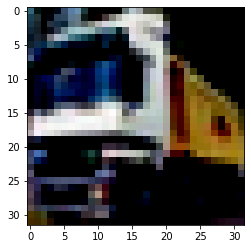

In [36]:
%matplotlib inline
plt.imshow(imgs.permute(1, 2, 0).numpy())

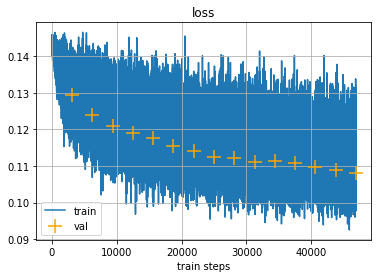

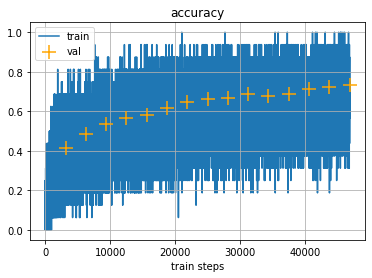

Epoch: 14
Train loss: 0.11205190513372422
Train acc: 0.67652
Val loss: 0.10816593205928803
Val acc: 0.7336


In [24]:
#1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(second_model.parameters(), lr=0.001, momentum=0.9)
NUM_EPOCH=15

train_model(second_model, criterion, optimizer, train_dataloader, test_dataloader)

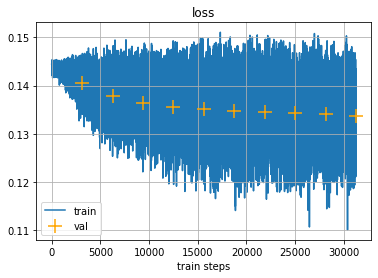

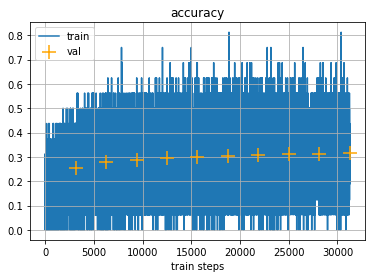

Epoch: 9
Train loss: 0.1345952027773857
Train acc: 0.3044
Val loss: 0.1337667075753212
Val acc: 0.3161


KeyboardInterrupt: ignored

In [100]:
#2
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mbase.parameters(), lr=0.001, momentum=0.9)
NUM_EPOCH=15

train_model(mbase, criterion, optimizer, train_dataloader, test_dataloader)